# **I. MOUNT GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **II. PREPARE THE DATASET**
Repeat the same steps from `baseline_model`. 



## **1. Make Variables to Store Paths**


In [ ]:
%cd '/content/drive/MyDrive/ML-dataset/augStructureRSMAS'
!ls

/content/drive/MyDrive/ML-dataset/augStructureRSMAS
ACER  coral-00.h5	 coral-baseline.tflite	MMEA	  validation
APAL  coral-00.tflite	 MALC			SSID
CNAT  coral-baseline.h5  MCAV			training


In [ ]:
train_dir = r'/content/drive/MyDrive/ML-dataset/augStructureRSMAS/training'  # Location of training images
valid_dir = r'/content/drive/MyDrive/ML-dataset/augStructureRSMAS/validation'  # Location of validation images

## **2. Preprocess the Data**

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator() #rescale and other augmentation parameters has already been set on script_augmented_image.ipynb
valid_datagen = ImageDataGenerator() #rescale and other augmentation parameters has already been set on script_augmented_image.ipynb

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    class_mode ='categorical')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(150, 150),
                                                    class_mode ='categorical')

Found 1514 images belonging to 7 classes.
Found 384 images belonging to 7 classes.


In [ ]:
image_folder = ['SSID', 'ACER','MMEA','APAL','CNAT','MALC','MCAV']
import matplotlib.pyplot as plt
import numpy as np

# **III. TRANSFER LEARNING USING DenseNet121**

DenseNet121 was selected because it is the newest model used by Gómez-Ríos et al. (2019) on "*Coral species identification with texture or structure images using a two-level classifier based on Convolutional Neural Networks*".

Further information: [Gómez-Ríos et al. (2019)](https://doi.org/10.1016/j.knosys.2019.104891), [CVPR (2017)](https://arxiv.org/abs/1608.06993), and [DenseNet121 function](https://keras.io/api/applications/densenet/#densenet121-function).

## **1. Import DenseNet121 Model Weight** 

In [ ]:
from tensorflow.keras.applications import DenseNet121

densenet_base = DenseNet121(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

densenet_base.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
_______________________

## **2. Define DenseNet121 as Model Architecture** 

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    densenet_base,
    tf.keras.layers.Dropout(0.5),
    # Add a global spatial average pooling layer
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    # Logistic layer - 7 classes
    tf.keras.layers.Dense(7, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 7,301,703
Trainable params: 7,218,055
Non-trainable params: 83,648
_________________________________________________________________


## **3. Train the New Model Architecture** 

In [ ]:
from keras.optimizers import Adam

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', tf.keras.metrics.Recall(name='recall')])

history = model.fit(train_generator,
                    epochs = 20,
                    steps_per_epoch = 20,
                    validation_data = valid_generator,
                    verbose = 1,
                    validation_steps = 3)

Epoch 1/20
20/20 [==============================] - 279s 13s/step - loss: 1.1063 - accuracy: 0.6078 - recall: 0.5500 - val_loss: 7.8186 - val_accuracy: 0.2292 - val_recall: 0.1979
Epoch 2/20
20/20 [==============================] - 242s 12s/step - loss: 0.6084 - accuracy: 0.8047 - recall: 0.7766 - val_loss: 3.7355 - val_accuracy: 0.3958 - val_recall: 0.3958
Epoch 3/20
20/20 [==============================] - 220s 11s/step - loss: 0.4103 - accuracy: 0.8592 - recall: 0.8447 - val_loss: 5.8956 - val_accuracy: 0.3229 - val_recall: 0.3229
Epoch 4/20
20/20 [==============================] - 219s 11s/step - loss: 0.3054 - accuracy: 0.8953 - recall: 0.8781 - val_loss: 3.9627 - val_accuracy: 0.6250 - val_recall: 0.6146
Epoch 5/20
20/20 [==============================] - 218s 11s/step - loss: 0.2823 - accuracy: 0.8984 - recall: 0.8844 - val_loss: 19.6499 - val_accuracy: 0.1562 - val_recall: 0.1562
Epoch 6/20
20/20 [==============================] - 213s 11s/step - loss: 0.2133 - accuracy: 0.9391

In [ ]:
# Save the trained model
model.save("coral-densene121.h5")

# **IV. EVALUATE THE PERFORMANCE**

## **1. Accuracy and Loss** 

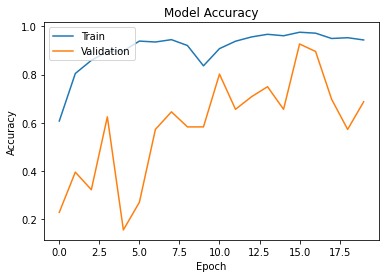

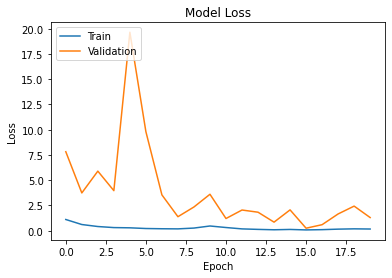

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

## **2. Classification Report and Confusion Matrix** 

In [ ]:
# Source: https://stackoverflow.com/questions/51282098/plotting-confusion-matrix-for-an-image-classification-model/51282672

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

target_names = image_folder
Y_pred = model.predict_generator(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Printing the classification report
print('Classification Report')
print(metrics.classification_report(valid_generator.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report
              precision    recall  f1-score   support

           0       0.14      0.02      0.03        62
           1       0.11      0.10      0.11        58
           2       0.19      0.27      0.22        48
           3       0.03      0.02      0.03        47
           4       0.24      0.48      0.32        54
           5       0.18      0.20      0.19        64
           6       0.15      0.14      0.14        51

    accuracy                           0.17       384
   macro avg       0.15      0.18      0.15       384
weighted avg       0.15      0.17      0.15       384



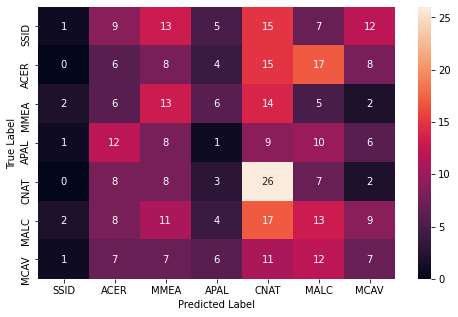

In [ ]:
# Visualizing the confusion matrix
import seaborn as sns

f, ax = plt.subplots(figsize = (8,5))
sns.heatmap(confusion_matrix(valid_generator.classes, y_pred), annot = True, fmt = '.0f', ax = ax)
ax.set_xticklabels(image_folder)
ax.set_yticklabels(image_folder)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **V. CONVERT SAVED MODEL TO TFLITE**

To deploy this on Native app, you need to convert it to file format .tflite.

In [ ]:
# Load the model
new_model= tf.keras.models.load_model(filepath="coral-densene121.h5")

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the TFLite model
with tf.io.gfile.GFile('coral-densene121.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfasf8afs/assets
